# Introduction to Machine Learning

Machine learning has become the dominant approach in the field of Artificial Intelligence (AI), a broad term encompassing efforts to make computational models that can perform complex tasks without the need for human guidance.

In this module, we will develop an intuitive understanding of of how computers learn from data. This will give us a good foundation for the rest of the course, and help us to understand some of the more cutting-edge model architectures used in text understanding and generation.

## A Brief History

The concept of machines learning how to do things has been discussed by scientists for decades.

In 1943, Warren McCulloch and Walter Pitts [explored](https://home.csulb.edu/~cwallis/382/readings/482/mccolloch.logical.calculus.ideas.1943.pdf) a mathematical model of our brains and nervous systems as a net of 'neurons' that respond to stimuli when 'excitation' exceeds a threshold.

Later, Frank Rosenblatt worked on the 'percepton' at Cornell University, writing that, *"We are about to witness the birth of...a machine capable of perceiving, recognizing and identifying its surroundings without any human training or control."*

<img src="https://news.cornell.edu/sites/default/files/styles/full_size/public/2019-09/0925_rosenblatt5.jpg?itok=7UpHtbRj" width=450>
Rosenblatt with the Mark I Perceptron, which performed image classification of some shapes successfully.

A decade later, in 1959, Arthur Samuel, a researcher at IBM, [wrote](https://people.csail.mit.edu/brooks/idocs/Samuel.pdf) that:

"A computer can be programmed so that it will learn to play a better game of checkers than can be played by the person who wrote the program".

The idea was emerging that computers could learn functions whereby they applied weights to input which then determined an output, such as whether the image is a square, or a circle.

Machine learning has of course soared in complexity and achievement since the 1940s and 50s, with a particularly intensive period of evolution from the 2010s onwards. There are several reasons for this, including:
* Advances in algorithms
* Availability of computational resources such as accelerators, or GPUs
* Varied and substantial datasets made available by the internet and by smartphones (representing the world and our behaviour)

Arthur Samuel, a researcher at IBM succinctly described a process for machine learning in 1962:

*"Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximise the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience."*

What I hope emerges here is the idea that ML is an approach different to traditional computer programming, where we typically give a computer a task and the exact instructions how to accomplish that task, as in this diagram:

<img src="https://github.com/rastringer/code_first_ml/blob/main/images/input_program_output.png?raw=true" width=650>

Instead, we want to create functions which learn from data such that they can receive inputs, apply weights to the features of those inputs (more on this soon), then generate an output. The saved weights from this process if what we call a 'model'.

<img src="https://github.com/rastringer/code_first_ml/blob/main/images/input_model_backprop.png?raw=true" width=650>


In this lesson, we will explore the basics of a neural network, which still closely resemble the vision of McCulloch, Pitts, Rosenblatt and others, building up to our own Multi-Layer Perceptron to classify images.

### The basics

Let's explore how we can craft functions to do the following:
* Make a prediction
* Calculate a loss

These are the essential first steps in ML. We make a prediction, and we need a metric to show how wrong we are.

### Random Noise

Firstly, we need some data to which we will try to fit a line. This could be predicting plant height from leaf size, or house price from square footage, for example. To keep things simple, we will try to fit a line to random 'noise'.

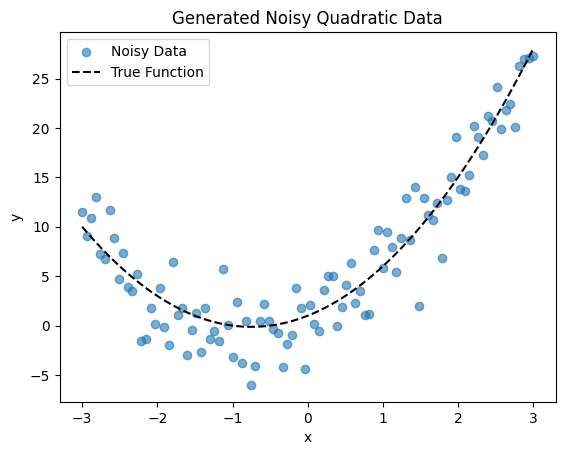

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data generation (same as before)
# Random seed so we can reproduce experiment if nec
np.random.seed(42)
# Generate 100 evenly spaced numbers from -3...3
X = np.linspace(-3, 3, 100)
# The underlying quadratic relationship: y = 2x² + 3x + 1
y_true = 2 * X**2 + 3 * X + 1
# Create random Gaussian noise with mean 0 and standard deviation 3
# (same shape as X so we can add it element-wise)
noise = np.random.normal(0, 3, size=X.shape)
# Add the noise to the true y values to simulate real-world data
y = y_true + noise

# Prepare data as list of (x, y) tuples
data = list(zip(X, y))

plt.scatter(X, y, label='Noisy Data', alpha=0.6)
plt.plot(X, y_true, color='black', linestyle='--', label='True Function')
plt.legend()
plt.title("Generated Noisy Quadratic Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


### Quadratic Function

Quadratic functions are useful to model the trajectory of projectiles, arcs and parabolic shapes. They are often used in optimization problems, or to fit lines to data.

The following function tries to predict weight from height, following this formula:

$a ⋅ x^2 + b ⋅ x + c$

Here, `a`, `b`, `c` are the parameters we will learn. They're like adjustable knobs the computer can tune to fit the data.


In [2]:
def predict_quadratic(x, a, b, c):
    return a * x**2 + b * x + c

### Loss Function

How do we know if our model is performing well? There are a variety of loss functions used in ML; one of the most common is Mean Squared Error (MSE). MSE is a formal way of saying the 'average of our mistakes'. The smaller the MSE, the better we are fitting the curve to the data.

This function calculates the difference between a prediction and the actual value, then squares that value.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

In the mathematical notation, $n$ is the number of examples in our data, $y_i$ is the actual value of example $i$, $\hat{y_i}$, pronounced "y hat" is the prediction.

Think of this like playing darts - each dart's distance from the bullseye gets squared, so big misses are more penalized. The goal is to minimize average error.

As with many calculations in ML, it may be easier to understand what's happening in the Python function. This function is more lines of code than what we would write in practice, however, showing the calculation steps in the loop should show exactly what is happening.

In [3]:
def mean_squared_error(data, a, b, c):
    total_error = 0
    for x, actual_y in data:
        predicted_y = predict_quadratic(x, a, b, c)
        error = predicted_y - actual_y
        squared_error = error ** 2
        total_error += squared_error

    mse = total_error / len(data)
    return mse


Now that we have an idea of how wrong our predictions are, we can try updating parameters to improve accuracy.

In the following function, we take one parameter (a, b, c) at a time, and try increasing, decreasing and keeping it the same. We use MSE to calculate what works best.

This is a 'brute force' way to learn.

In [4]:
# Manual parameter update using simple finite differences (crude update)
def try_update_param(param, delta, fixed_params, data, param_index):
    a, b, c = fixed_params

    # Try positive delta
    params_pos = [a, b, c]
    params_pos[param_index] = param + delta
    loss_pos = mean_squared_error(data, *params_pos)

    # Try negative delta
    params_neg = [a, b, c]
    params_neg[param_index] = param - delta
    loss_neg = mean_squared_error(data, *params_neg)

    # Current loss without change
    params_curr = [a, b, c]
    params_curr[param_index] = param
    loss_curr = mean_squared_error(data, *params_curr)

    # Choose best option
    if loss_pos < loss_curr and loss_pos < loss_neg:
        return param + delta, loss_pos
    elif loss_neg < loss_curr and loss_neg < loss_pos:
        return param - delta, loss_neg
    else:
        return param, loss_curr

This process is cumbersone because we have to evaluate the model multiple times, and there are no gradients (slopes) calculated, so just comparing up, down and same is limited. This scenario is comparable to trying to find your way down a mountain blindfolded, just feeling around. This analogy will soon be extended...

Let's visualize our current training process:

Epoch 0: a=-1.315, b=-0.321, c=-0.243, Loss=254.937
Epoch 5: a=-0.815, b=0.179, c=0.257, Loss=180.331
Epoch 10: a=-0.315, b=0.679, c=0.757, Loss=119.246
Epoch 15: a=0.185, b=1.179, c=1.257, Loss=71.681
Epoch 20: a=0.685, b=1.679, c=1.757, Loss=37.637
Epoch 25: a=1.185, b=2.179, c=2.257, Loss=17.113
Epoch 30: a=1.685, b=2.679, c=2.157, Loss=9.466
Epoch 35: a=1.785, b=3.079, c=1.657, Loss=8.047
Epoch 40: a=1.885, b=3.079, c=1.157, Loss=7.586
Epoch 45: a=1.985, b=3.079, c=0.757, Loss=7.351
Time taken:0:00:00.035129


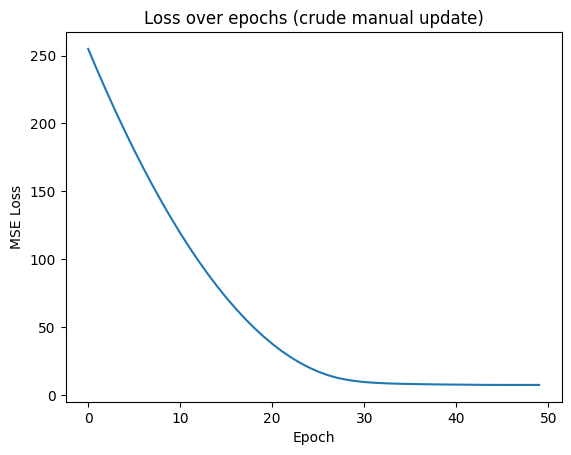

In [5]:
from datetime import datetime

# Initialize parameters randomly
a, b, c = np.random.randn(3)
delta = 0.1
epochs = 50

loss_history = []
predictions_history = []
start = datetime.now()

for epoch in range(epochs):
    a, loss_a = try_update_param(a, delta, (a, b, c), data, 0)
    b, loss_b = try_update_param(b, delta, (a, b, c), data, 1)
    c, loss_c = try_update_param(c, delta, (a, b, c), data, 2)

    loss = max(loss_a, loss_b, loss_c)
    loss_history.append(loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: a={a:.3f}, b={b:.3f}, c={c:.3f}, Loss={loss:.3f}")
        y_pred = predict_quadratic(X, a, b, c)
        predictions_history.append((epoch, y_pred.copy()))

end = datetime.now()
manual_time = end-start
print(f"Time taken:{manual_time}")

# Plot loss over epochs
plt.plot(loss_history)
plt.title("Loss over epochs (crude manual update)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

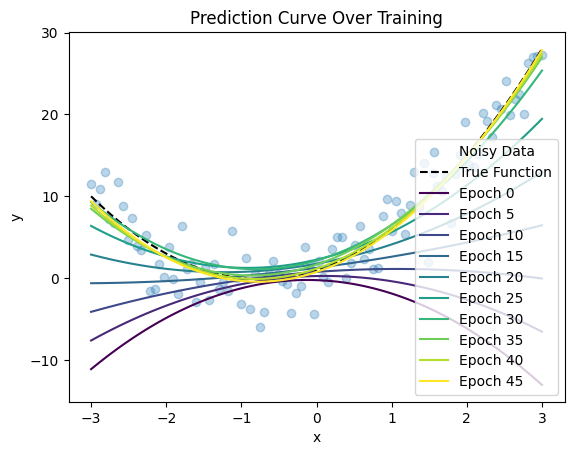

In [6]:
plt.scatter(X, y, alpha=0.3, label="Noisy Data")
plt.plot(X, y_true, label="True Function", color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(predictions_history)))
for (epoch, pred), color in zip(predictions_history, colors):
    plt.plot(X, pred, color=color, label=f"Epoch {epoch}")

plt.title("Prediction Curve Over Training")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Vectorized MSE

If you're familiar with Python, you have probably come across vectorized operations. Vectorization refers to the process of performing calculations across entire arrays, matricies or tensors (more on these soon) at once, rather than using loops to iterate through values one by one.

#### Numpy

Numpy is a popular scientific programming library for Python and we will use several of its methods today. Numpy makes vector operations easy - and will vastly simplify our `mean_squared_error` function. We'll give the updated function a new name to avoid confusion.
Here again is MSE in vanilla Python:

```
def mean_squared_error(data, a, b, c):
    total_error = 0
    for x, actual_y in data:
        predicted_y = predict_quadratic(x, a, b, c)
        error = predicted_y - actual_y
        squared_error = error ** 2
        total_error += squared_error

    mse = total_error / len(data)
    return mse
```

In Numpy, we simply use the `np.mean` method across the squared difference between our predictions and actuals.

In [7]:
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

Let's rewrite the function to update params using our new, vectorized MSE

In [8]:
def try_update_param(param, delta, fixed_params, x, y, param_index):
    """
    param: current value of the parameter to update
    delta: step size to try (+delta and -delta)
    fixed_params: tuple/list of the other two parameters
    param_index: index of param in (a,b,c) to know position

    Returns the updated param and the corresponding loss.
    """
    a, b, c = fixed_params

    # Try positive delta
    params_pos = [a, b, c]
    params_pos[param_index] = param + delta
    y_pred_pos = predict_quadratic(*params_pos, x)
    loss_pos = mse_loss(y_pred_pos, y)

    # Try negative delta
    params_neg = [a, b, c]
    params_neg[param_index] = param - delta
    y_pred_neg = predict_quadratic(*params_neg, x)
    loss_neg = mse_loss(y_pred_neg, y)

    # Current loss without change
    params_curr = [a, b, c]
    params_curr[param_index] = param
    y_pred_curr = predict_quadratic(*params_curr, x)
    loss_curr = mse_loss(y_pred_curr, y)

    # Choose best option
    if loss_pos < loss_curr and loss_pos < loss_neg:
        return param + delta, loss_pos
    elif loss_neg < loss_curr and loss_neg < loss_pos:
        return param - delta, loss_neg
    else:
        return param, loss_curr

Epoch 0: a=-0.702, b=-0.061, c=0.304, Loss=103.684
Epoch 5: a=-0.802, b=0.439, c=-0.196, Loss=94.673
Epoch 10: a=-1.302, b=0.939, c=-0.696, Loss=73.495
Epoch 15: a=-1.802, b=1.439, c=-1.196, Loss=52.469
Epoch 20: a=-1.802, b=1.439, c=-1.196, Loss=52.233
Epoch 25: a=-1.802, b=1.439, c=-1.196, Loss=52.233
Epoch 30: a=-1.802, b=1.439, c=-1.196, Loss=52.233
Epoch 35: a=-1.802, b=1.439, c=-1.196, Loss=52.233
Epoch 40: a=-1.802, b=1.439, c=-1.196, Loss=52.233
Epoch 45: a=-1.802, b=1.439, c=-1.196, Loss=52.233
Time taken:0:00:00.006135


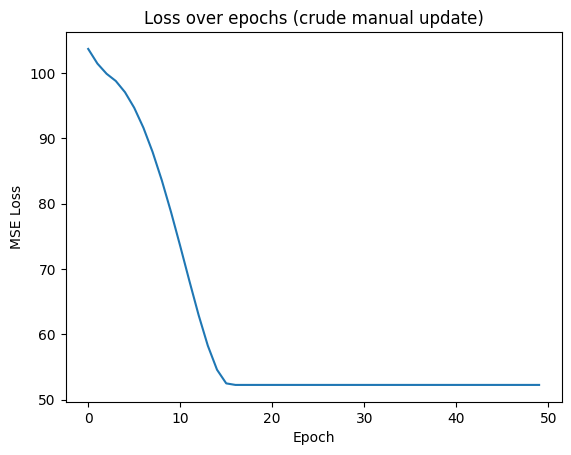

In [9]:
a, b, c = np.random.randn(3)
delta = 0.1
epochs = 50

loss_history = []

start = datetime.now()
for epoch in range(epochs):
    # Update a
    a, loss_a = try_update_param(a, delta, (a, b, c), X, y, 0)
    # Update b
    b, loss_b = try_update_param(b, delta, (a, b, c), X, y, 1)
    # Update c
    c, loss_c = try_update_param(c, delta, (a, b, c), X, y, 2)

    # Use the worst loss among the updates (or average, but worst is safe)
    loss = max(loss_a, loss_b, loss_c)
    loss_history.append(loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: a={a:.3f}, b={b:.3f}, c={c:.3f}, Loss={loss:.3f}")

end = datetime.now()
vectorized_time = end - start
print(f"Time taken:{vectorized_time}")

# Plot loss over epochs
plt.plot(loss_history)
plt.title("Loss over epochs (crude manual update)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()


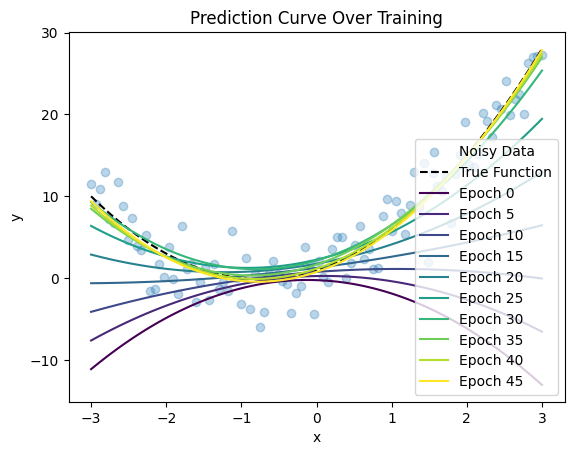

In [10]:
plt.scatter(X, y, alpha=0.3, label="Noisy Data")
plt.plot(X, y_true, label="True Function", color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(predictions_history)))
for (epoch, pred), color in zip(predictions_history, colors):
    plt.plot(X, pred, color=color, label=f"Epoch {epoch}")

plt.title("Prediction Curve Over Training")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [11]:
print(f"Vectorized time {manual_time - vectorized_time} faster than manual time")

Vectorized time 0:00:00.028994 faster than manual time


Though the vectorized operation is only milliseconds faster, such gains over millions and billions of calculations will be significant!

### Gradient Descent

So far, our model learns by trial and error — trying random tweaks. But we can be smarter: if we can calculate the slope of the loss function, we’ll know which direction reduces error the fastest.

Imagine you're at the summit of a mountain and it's getting misty, cold and dark. You can't see the bottom, but you can feel which way the ground slopes. Gradient descent means we follow the steepest downward slope to reach the lowest point, which is the minimum loss.

#### Intuitive algorithm:

We calculate which direction provides the best option for minimizing the loss, and take a small 'step' in that direction. Repeat.

The parameters, or 'weights' of the model, are updated iteratively using the gradients of the loss function. ML training is in part a process of making millions or more of these tiny adjustments until the model finds the best weights for a task.

### Mathematical Formulation

Here's the more academic mathematical formulation:

For parameters θ = [θ₀, θ₁, ..., θₙ]:

**Loss Function:** $J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \left(h_\theta(x^{(i)}) - y^{(i)}\right)^2$

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

**Gradient:** $\nabla J(\theta_j) = \frac{1}{m} \sum_{i=1}^{m} \left(h_\theta(x^{(i)}) - y^{(i)}\right) x^{(i)}_j$

**Update Rule:** $\theta_j = \theta_j - \alpha \cdot \nabla J(\theta_j)$

Where:
- m = number of training examples
- α = learning rate
- hθ(x) = hypothesis function (the model's prediction)

This just means:

* Take the current parameters (θ)

* Compute the gradient (the direction of steepest increase)

* Step a little in the opposite direction to reduce loss

* α (alpha) is the learning rate — how big a step we take.

* If we take too big a step, we overshoot the valley.

* If our steps are too small, we will take longer to reach the bottom.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create dataset
np.random.seed(42)
X = np.linspace(-3, 3, 100)
y_true = 2 * X**2 + 3 * X + 1
noise = np.random.normal(0, 3, size=X.shape)
y = y_true + noise

# Initialize parameters
a, b, c = np.random.randn(3)
learning_rate = 0.01
epochs = 100

loss_history = []
predictions_history = []

for epoch in range(epochs):
    # Forward pass: predict
    y_pred = predict_quadratic(X, a, b, c)
    loss = mse_loss(y_pred, y)
    loss_history.append(loss)

    if epoch % 10 == 0 or epoch == epochs - 1:
        predictions_history.append((epoch, y_pred.copy()))

    # Backward pass: compute gradients
    # These lines calculate the gradients / derivatives that inform:
    # which direction each parameter should move (pos or neg)
    # how steep the slope is (how much to change)
    N = len(X)
    dL_da = (2/N) * np.sum((y_pred - y) * X**2)
    dL_db = (2/N) * np.sum((y_pred - y) * X)
    dL_dc = (2/N) * np.sum((y_pred - y) * 1)

    # Update parameters
    # Here, we move each parameter in the
    # opposite direction of its gradient
    a -= learning_rate * dL_da
    b -= learning_rate * dL_db
    c -= learning_rate * dL_dc

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3}: a={a:.3f}, b={b:.3f}, c={c:.3f}, Loss={loss:.3f}")


Epoch   0: a=-0.192, b=-0.207, c=-0.113, Loss=267.007
Epoch  10: a=2.062, b=1.327, c=0.323, Loss=17.899
Epoch  20: a=2.090, b=2.143, c=0.343, Loss=10.296
Epoch  30: a=2.088, b=2.577, c=0.356, Loss=8.158
Epoch  40: a=2.086, b=2.807, c=0.368, Loss=7.552
Epoch  50: a=2.084, b=2.930, c=0.379, Loss=7.380
Epoch  60: a=2.082, b=2.995, c=0.389, Loss=7.331
Epoch  70: a=2.080, b=3.030, c=0.399, Loss=7.316
Epoch  80: a=2.079, b=3.048, c=0.407, Loss=7.312
Epoch  90: a=2.077, b=3.058, c=0.415, Loss=7.310


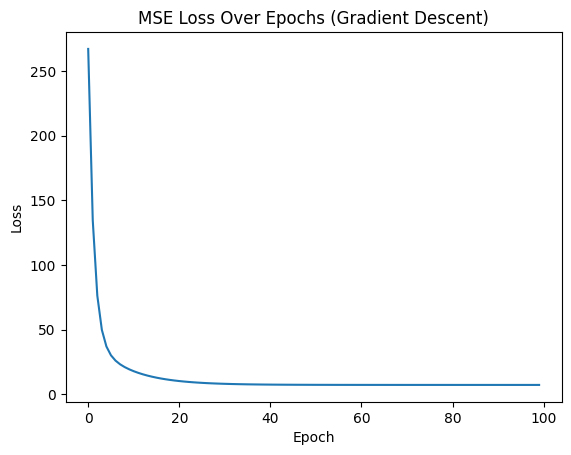

In [13]:
plt.plot(loss_history)
plt.title("MSE Loss Over Epochs (Gradient Descent)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


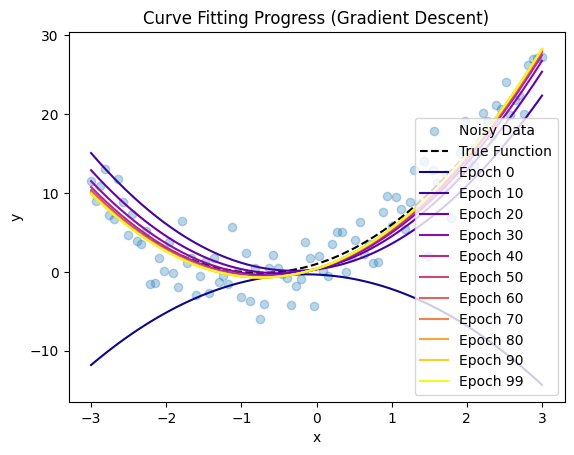

In [14]:
plt.scatter(X, y, alpha=0.3, label="Noisy Data")
plt.plot(X, y_true, color='black', linestyle='--', label="True Function")

colors = plt.cm.plasma(np.linspace(0, 1, len(predictions_history)))
for (epoch, pred), color in zip(predictions_history, colors):
    plt.plot(X, pred, color=color, label=f"Epoch {epoch}")

plt.legend()
plt.title("Curve Fitting Progress (Gradient Descent)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


As we can see from this toy example, gradient descent offers several benefits over manual updates:
* Smart direction - gradients tell us which way to go efficiently
* Smooth progress - we take steps proportional to the slope steepness
* Scale - just imagine doing manual updates for large models!

### Model Class

Now that the basics of a 'model' are coming together, lets add our functions to a Python class to keep the methods together, make it easy to do training and prediction, and have somewhere to add further capabilities. This mimics how machine learning frameworks like PyTorch and MXNet organize models.

In [15]:
class QuadraticModel:
    def __init__(self, seed=42):
        np.random.seed(seed)
        self.a = np.random.randn()
        self.b = np.random.randn()
        self.c = np.random.randn()
        self.predictions_history = []

    def predict(self, x):
        return self.a * x**2 + self.b * x + self.c

    def compute_gradients(self, x, y_true):
        y_pred = self.predict(x)
        error = y_pred - y_true
        N = len(x)
        dL_da = (2/N) * np.sum(error * x**2)
        dL_db = (2/N) * np.sum(error * x)
        dL_dc = (2/N) * np.sum(error)
        loss = mse_loss(y_pred, y_true)
        return loss, dL_da, dL_db, dL_dc

    def update_parameters(self, grads, lr):
        _, dL_da, dL_db, dL_dc = grads
        self.a -= lr * dL_da
        self.b -= lr * dL_db
        self.c -= lr * dL_dc

    def train(self, x, y, epochs=100, lr=0.01, verbose=True):
        loss_history = []

        for epoch in range(epochs):
            loss, dL_da, dL_db, dL_dc = self.compute_gradients(x, y)
            self.update_parameters((loss, dL_da, dL_db, dL_dc), lr)
            loss_history.append(loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
                y_pred = self.predict(x)
                self.predictions_history.append((epoch, y_pred.copy()))
                if verbose:
                    print(f"Epoch {epoch:3}: a={self.a:.3f}, b={self.b:.3f}, c={self.c:.3f}, Loss={loss:.3f}")

        return loss_history

In [16]:
# Create dataset
np.random.seed(42)
X = np.linspace(-3, 3, 100)
y_true = 2 * X**2 + 3 * X + 1 + np.random.normal(0, 3, size=X.shape)
noise = np.random.normal(0, 3, size=X.shape)

# Train model
model = QuadraticModel()
loss_history = model.train(X, y, epochs=100, lr=0.01)

Epoch   0: a=1.015, b=0.058, c=0.741, Loss=78.668
Epoch  10: a=1.976, b=1.468, c=0.884, Loss=16.281
Epoch  20: a=1.995, b=2.218, c=0.854, Loss=9.879
Epoch  30: a=2.001, b=2.616, c=0.825, Loss=8.065
Epoch  40: a=2.006, b=2.828, c=0.798, Loss=7.547
Epoch  50: a=2.010, b=2.941, c=0.774, Loss=7.397
Epoch  60: a=2.015, b=3.001, c=0.751, Loss=7.350
Epoch  70: a=2.018, b=3.033, c=0.731, Loss=7.334
Epoch  80: a=2.022, b=3.050, c=0.712, Loss=7.327
Epoch  90: a=2.025, b=3.059, c=0.694, Loss=7.323
Epoch  99: a=2.028, b=3.063, c=0.680, Loss=7.321


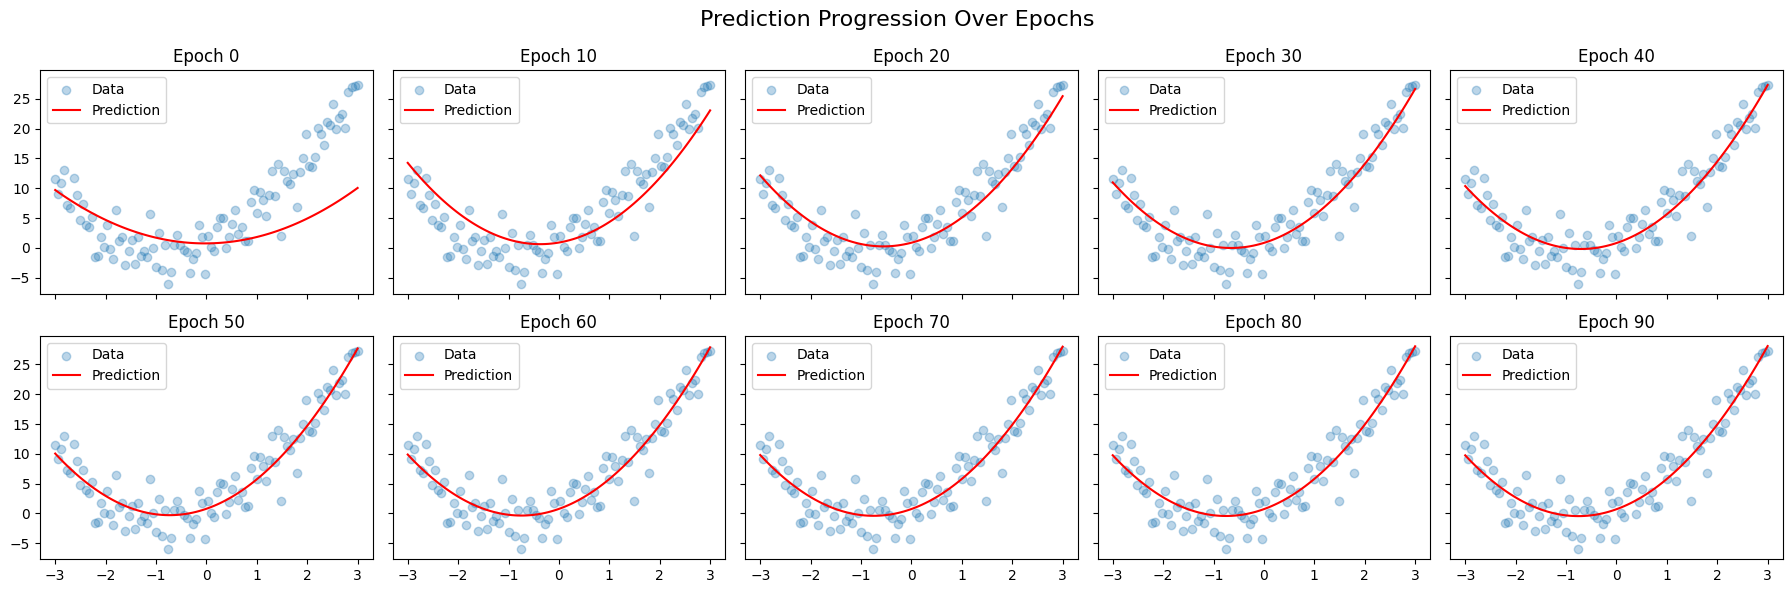

In [17]:
def plot_predictions_over_time(X, y, model):
    fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (epoch, y_pred) in enumerate(model.predictions_history[:10]):
        ax = axes[i]
        ax.scatter(X, y, label='Data', alpha=0.3)
        ax.plot(X, y_pred, color='red', label='Prediction')
        ax.set_title(f"Epoch {epoch}")
        ax.legend()

    fig.suptitle("Prediction Progression Over Epochs", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_predictions_over_time(X, y, model)


### Backpropagation

Now that we know how to compute gradients for a simple function, let’s see how this works in a real neural network.

In a network, outputs are produced through a series of connected functions — just like a mathematical recipe.
Backpropagation uses the chain rule from calculus to trace how each parameter contributed to the final error.

In [18]:
x = 2.0
a, b, c = 1.0, 2.0, 1.0
y_true = 15.0

# Forward pass: input -> prediction -> loss
# Each intermediate step (`z1`, `z2`, `z3`) stores a partial
# computation which we need for the 'backward pass'.
z1 = x**2         # z1 = x²
z2 = a * z1       # z2 = a * x²
z3 = b * x        # z3 = b * x
z4 = z2 + z3 + c  # z4 = ax² + bx + c
y_pred = z4

# Loss
loss = (y_pred - y_true)**2


In [19]:
# Backpropagation
# Start with how much the loss changes when the prediction changes
dL_dypred = 2 * (y_pred - y_true)

# Gradients w.r.t each parameter
dypred_da = z1          # ∂y_pred/∂a = x²
dypred_db = x           # ∂y_pred/∂b = x
dypred_dc = 1           # ∂y_pred/∂c = 1

# Chain rule
# Multiply dl_dypred by how much each parameter affects the prediction.
dL_da = dL_dypred * dypred_da
dL_db = dL_dypred * dypred_db
dL_dc = dL_dypred * dypred_dc


In [20]:
# Single data point since we're just trying to learn the pattern
# This means that when x = 2, the function's ouptut should be 15
# As a reminder, we're fitting a quadratic function: y = ax² + bx + c
x = 2.0
y_true = 15.0

# Parameters, or "weights" in our simple network
a, b, c = 1.0, 2.0, 1.0
learning_rate = 0.01

print("FORWARD PASS")
print("Following the computation forward, step by step:")

# --- Forward pass ---
# This is like signals flowing forward through a neural network
z1 = x**2         # First operation: square the input
print(f"z1 = x² = {x}² = {z1}")

z2 = a * z1       # Multiply by parameter 'a'
print(f"z2 = a × z1 = {a} × {z1} = {z2}")

z3 = b * x        # Multiply input by parameter 'b'
print(f"z3 = b × x = {b} × {x} = {z3}")

z4 = z2 + z3 + c  # Add everything together (our prediction)
print(f"z4 = z2 + z3 + c = {z2} + {z3} + {c} = {z4}")

y_pred = z4
print(f"Final prediction: {y_pred}")

# Calculate how wrong we were
loss = (y_pred - y_true)**2
print(f"Target was {y_true}, we predicted {y_pred}")
print(f"Loss (squared error): ({y_pred} - {y_true})² = {loss:.4f}")

print("\nBACKWARD PASS")
print("Now we trace the error backwards to find which parameters need adjustments:")

# --- Backward pass (chain rule) ---
# We work backwards from the loss,working out how much
# each parameter contributed to inaccuracies

# For parameter 'a': it affects prediction through z2 = a * x²
# Chain rule: dL/da = (dL/dy_pred) × (dy_pred/da)
# Since y_pred = ax² + bx + c, then dy_pred/da = x²
dL_da = dL_dypred * x**2
print(f"dL/da = dL/dy_pred × x² = {dL_dypred:.4f} × {x**2} = {dL_da:.4f}")
print(f"Parameter 'a' is multiplied by x²={x**2}, so it has {x**2}x the impact on our mistake")

# For parameter 'b': it affects prediction through z3 = b * x
# dy_pred/db = x
dL_db = dL_dypred * x
print(f"dL/db = dL/dy_pred × x = {dL_dypred:.4f} × {x} = {dL_db:.4f}")
print(f"Parameter 'b' is multiplied by x={x}, so it has {x}x the impact")

# For parameter 'c': it's added directly to prediction
# dy_pred/dc = 1 (adding c by 1 increases prediction by 1)
dL_dc = dL_dypred * 1
print(f"dL/dc = dL/dy_pred × 1 = {dL_dypred:.4f} × 1 = {dL_dc:.4f}")
print(f"Parameter 'c' is added directly, so it has 1x the impact")

print(f"\nRESULTS")
print(f"Parameter 'a' gets blame score: {dL_da:.4f}")
print(f"Parameter 'b' gets blame score: {dL_db:.4f}")
print(f"Parameter 'c' gets blame score: {dL_dc:.4f}")
print("Bigger blame = bigger adjustment needed!")

print(f"\nGRADIENT DESCENT UPDATE")
print("Now we adjust each parameter proportional to their inaccuracy:")
print(f"Old parameters: a={a:.4f}, b={b:.4f}, c={c:.4f}")


# --- Gradient descent update ---
# Move each parameter in the opposite direction of its gradient
# (negative because we want to reduce loss, not increase it)
a -= learning_rate * dL_da
b -= learning_rate * dL_db
c -= learning_rate * dL_dc

print(f"a = a - learning_rate × dL/da = {a + learning_rate * dL_da:.4f} - {learning_rate} × {dL_da:.4f} = {a:.4f}")
print(f"b = b - learning_rate × dL/db = {b + learning_rate * dL_db:.4f} - {learning_rate} × {dL_db:.4f} = {b:.4f}")
print(f"c = c - learning_rate × dL/dc = {c + learning_rate * dL_dc:.4f} - {learning_rate} × {dL_dc:.4f} = {c:.4f}")

print(f"\nUpdated parameters: a={a:.4f}, b={b:.4f}, c={c:.4f}")

FORWARD PASS
Following the computation forward, step by step:
z1 = x² = 2.0² = 4.0
z2 = a × z1 = 1.0 × 4.0 = 4.0
z3 = b × x = 2.0 × 2.0 = 4.0
z4 = z2 + z3 + c = 4.0 + 4.0 + 1.0 = 9.0
Final prediction: 9.0
Target was 15.0, we predicted 9.0
Loss (squared error): (9.0 - 15.0)² = 36.0000

BACKWARD PASS
Now we trace the error backwards to find which parameters need adjustments:
dL/da = dL/dy_pred × x² = -12.0000 × 4.0 = -48.0000
Parameter 'a' is multiplied by x²=4.0, so it has 4.0x the impact on our mistake
dL/db = dL/dy_pred × x = -12.0000 × 2.0 = -24.0000
Parameter 'b' is multiplied by x=2.0, so it has 2.0x the impact
dL/dc = dL/dy_pred × 1 = -12.0000 × 1 = -12.0000
Parameter 'c' is added directly, so it has 1x the impact

RESULTS
Parameter 'a' gets blame score: -48.0000
Parameter 'b' gets blame score: -24.0000
Parameter 'c' gets blame score: -12.0000
Bigger blame = bigger adjustment needed!

GRADIENT DESCENT UPDATE
Now we adjust each parameter proportional to their inaccuracy:
Old parame

### Learning Check

In [21]:
import json, os, sys
from IPython.display import display, Markdown

# Try ipywidgets for a nicer UI; fall back to input() if not available
try:
    import ipywidgets as widgets
    HAVE_WIDGETS = True
except Exception:
    HAVE_WIDGETS = False

import json, urllib.request

QUIZ_URL = "https://raw.githubusercontent.com/rastringer/ai_sec_course_resources/refs/heads/main/1_intro_to_ml/1_1_quiz.json"

def load_quiz_from_url(url=QUIZ_URL):
    with urllib.request.urlopen(url) as resp:
        return json.loads(resp.read().decode("utf-8"))

quiz = load_quiz_from_url()
title = quiz.get("title", "Quiz")
questions = quiz["questions"]
bonus = quiz.get("bonus", [])

display(Markdown(f"# {title}"))

if HAVE_WIDGETS:
    rows = []
    answer_widgets = {}
    for q in questions:
        # Use widgets.HTML instead of Markdown
        q_html = widgets.HTML(value=f"<b>{q['question']}</b>")
        opts = q["options"]
        opts_list = [f"{k}) {v}" for k, v in opts.items()]
        rb = widgets.RadioButtons(
          options=opts_list,
          description="",
          layout=widgets.Layout(width="auto"),
          value=None  # 👈 prevents auto-selecting the first option
      )

        answer_widgets[q["id"]] = rb
        rows.extend([q_html, rb])

    submit = widgets.Button(description="Submit Quiz", button_style="primary")
    output = widgets.Output()


    def on_submit(_):
        with output:
            output.clear_output()
            score = 0
            total = len(questions)
            for q in questions:
                chosen = answer_widgets[q["id"]].value
                # chosen like "C) Weights/parameters...", we only need the letter before ')'
                chosen_key = chosen.split(")")[0] if chosen else None
                correct = q["answer"]
                if chosen_key == correct:
                    score += 1
                    display(Markdown(f"✅ **Q:** {q['question']}  \n**Correct!** {q['explanation']}"))
                else:
                    display(Markdown(
                        f"❌ **Q:** {q['question']}  \n**Correct answer:** {correct}. {q['explanation']}"
                    ))
            display(Markdown(f"## Final Score: **{score} / {total}**"))
            if score == total:
                display(Markdown("🎉 Excellent! You’ve nailed the core ML concepts."))
            elif score >= total * 0.6:
                display(Markdown("👍 Good job! Revisit any missed explanations and try again."))
            else:
                display(Markdown("🧩 Keep practicing — review loss, gradients, and the update rule."))

            if bonus:
                display(Markdown("----"))
                display(Markdown("### 💬 Bonus (open-ended)"))
                for b in bonus:
                    display(Markdown(f"- {b['prompt']}"))

    submit.on_click(on_submit)
    display(widgets.VBox(rows + [submit, output]))

else:
    # Fallback
    print("(ipywidgets not available — using basic input/print UI)\n")
    score = 0
    total = len(questions)
    for q in questions:
        print(q["question"])
        for k, v in q["options"].items():
            print(f"  {k}. {v}")
        ans = input("Your answer (A/B/C/D): ").strip().upper()
        if ans == q["answer"]:
            score += 1
            print("Correct!", q["explanation"])
        else:
            print(f"Incorrect. Correct answer: {q['answer']} — {q['explanation']}")
        print("-" * 60)
    print(f"Score: {score}/{total}")
    if bonus:
        print("\nBonus prompts:")
        for b in bonus:
            print(" -", b["prompt"])


# Intro to ML — Knowledge Check

### Summary

In this notebook, we covered the basic building blocks of a neural network including:
* Loss function
* Gradient descent
* Backpropagation

In the next notebook, we will look at how we introduce non-linearity into our networks with *activation* functions.
